In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [3]:
INFILE = './processed/l1/0611/2V_LED/l1.h5'
BINS = 100

In [4]:
store = pd.HDFStore(INFILE)
df = store['df']
store.close()

In [5]:
charges = df['charge'].unique()
binning = np.linspace(np.min(charges), np.max(charges), BINS+1)

hist, _ = np.histogram(charges, binning)
hist_0 = np.concatenate([[hist[0]], hist])

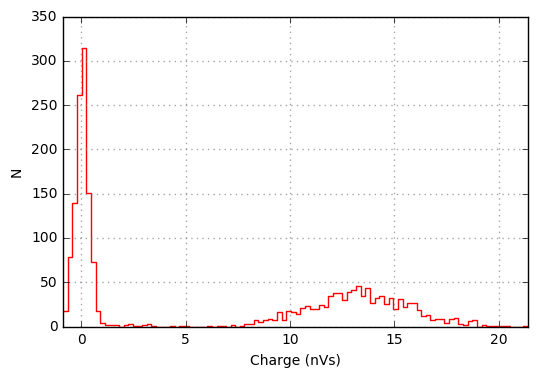

In [6]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.set_xlim(np.min(charges), np.max(charges))

ax.step(
    binning, hist_0, alpha=1, drawstyle='steps-pre', linewidth=1,
    linestyle='-', color='r'
)

ax.set_xlabel('Charge (nVs)')
ax.set_ylabel('N')
for ymaj in ax.yaxis.get_majorticklocs():
    ax.axhline(y=ymaj, ls=':', color='gray', alpha=0.7, linewidth=1)
for xmaj in ax.xaxis.get_majorticklocs():
    ax.axvline(x=xmaj, ls=':', color='gray', alpha=0.7, linewidth=1)

In [7]:
from scipy.optimize import curve_fit

In [8]:
# cut away empty waveforms
hist_cut = hist[12:]
binning_cut = binning[12:]
bin_centres = (binning_cut[:-1] + binning_cut[1:])/2.

In [9]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [21]:
# initial guess
p0 = [1., 0., 1.]
coeff, var_matrix = curve_fit(gauss, bin_centres, hist_cut, p0=p0)
hist_fit = gauss(bin_centres, *coeff)
pe = (coeff[1] / coeff[2])**2
# internal impedence of DDC2 is 150 ohms
gain = (coeff[1] * 1e-9) / (pe * 150. * 1.6e-19)

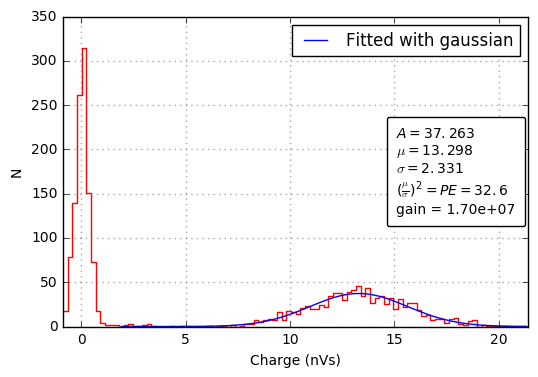

In [22]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.set_xlim(np.min(charges), np.max(charges))

ax.step(
    binning, hist_0, alpha=1, drawstyle='steps-pre', linewidth=1,
    linestyle='-', color='r'
)
ax.plot(bin_centres, hist_fit, label='Fitted with gaussian')

ax.set_xlabel('Charge (nVs)')
ax.set_ylabel('N')
for ymaj in ax.yaxis.get_majorticklocs():
    ax.axhline(y=ymaj, ls=':', color='gray', alpha=0.7, linewidth=1)
for xmaj in ax.xaxis.get_majorticklocs():
    ax.axvline(x=xmaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    
ax.legend()
at = AnchoredText(r'$A = {0:.3f}$'.format(coeff[0]) + '\n' +
                  r'$\mu = {0:.3f}$'.format(coeff[1]) + '\n' +
                  r'$\sigma = {0:.3f}$'.format(coeff[2]) + '\n' +
                  r'$(\frac{\mu}{\sigma})^2 = PE = ' + r'{0:.1f}$'.format(pe) + '\n' +
                  r'gain = {0:.2e}'.format(gain),
                  prop=dict(size=10), frameon=True, loc=5)
at.patch.set_boxstyle("round,pad=0.3,rounding_size=0.2")
ax.add_artist(at)